# Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,GlobalAveragePooling2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
folders=glob('/content/drive/MyDrive/Data/Body Parts Dataset/*')
folders

['/content/drive/MyDrive/Data/Body Parts Dataset/Eye',
 '/content/drive/MyDrive/Data/Body Parts Dataset/Ear',
 '/content/drive/MyDrive/Data/Body Parts Dataset/Elbow',
 '/content/drive/MyDrive/Data/Body Parts Dataset/Nose',
 '/content/drive/MyDrive/Data/Body Parts Dataset/Knee',
 '/content/drive/MyDrive/Data/Body Parts Dataset/Belly',
 '/content/drive/MyDrive/Data/Body Parts Dataset/Foot',
 '/content/drive/MyDrive/Data/Body Parts Dataset/Hand',
 '/content/drive/MyDrive/Data/Body Parts Dataset/Neck',
 '/content/drive/MyDrive/Data/Body Parts Dataset/Shoulders']

# Total Images

In [ ]:
image_cnt=glob('/content/drive/MyDrive/Data/Body Parts Dataset/*/*jpg')
print(len(image_cnt))

2092


# Import Data into tensorflow object

In [ ]:
IMG_SIZE=[224,224]
BATCH_SIZE=32
train_ds=tf.keras.utils.image_dataset_from_directory(data,validation_split=0.2,batch_size=BATCH_SIZE,image_size=IMG_SIZE,
                                                     subset='training',shuffle=True,seed=123)

Found 2092 files belonging to 10 classes.
Using 1674 files for training.


In [ ]:
valid_ds=tf.keras.utils.image_dataset_from_directory(data,validation_split=0.2,batch_size=BATCH_SIZE,image_size=IMG_SIZE,
                                                     subset='validation',shuffle=True,seed=123)

Found 2092 files belonging to 10 classes.
Using 418 files for validation.


In [ ]:
class_names=train_ds.class_names
print(class_names)

['Belly', 'Ear', 'Elbow', 'Eye', 'Foot', 'Hand', 'Knee', 'Neck', 'Nose', 'Shoulders']


In [ ]:
for image_batch,label_batch in train_ds.take(1):
  print(image_batch.shape)
  print(label_batch.numpy)

(32, 224, 224, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([6, 5, 1, 6, 0, 6, 8, 4, 9, 6, 8, 5, 4, 3, 0, 8, 3, 3, 2, 0, 4, 2,
       7, 6, 1, 9, 4, 8, 3, 7, 0, 5], dtype=int32)>>


# Check Random Image

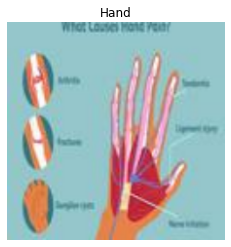

In [ ]:
for image_batch,label_batch in train_ds.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.title(class_names[label_batch[0]])
  plt.axis('off')

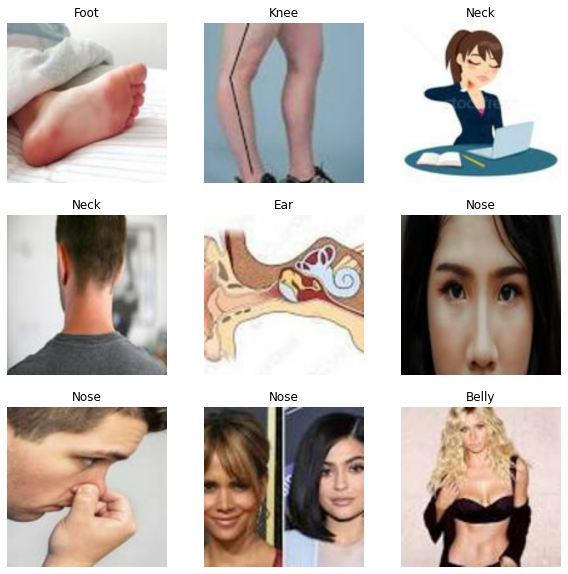

In [ ]:
fig=plt.figure(figsize=(10,10))
for image_batch,label_batch in train_ds.take(1):
  for i in range(9):
    fig.add_subplot(3,3,i+1),plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

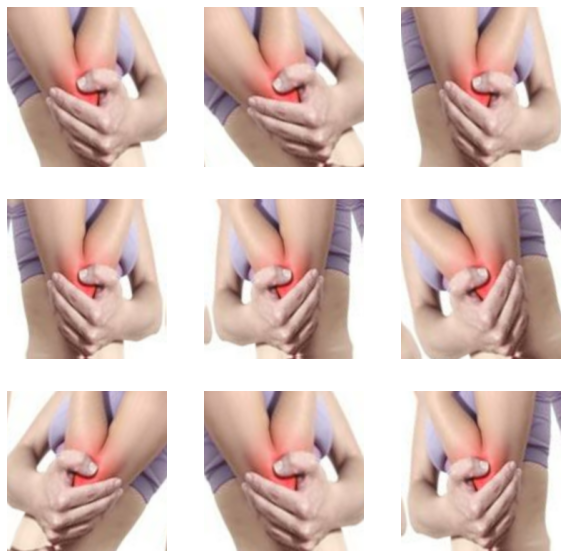

In [ ]:
fig=plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    fig.add_subplot(3,3,i+1),plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Resize & Rescaling

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Model Building

In [ ]:
IMG_SHAPE = IMG_SIZE + [3]
base_model = VGG19(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
inputs = base_model.input
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
global_average_layer = GlobalAveragePooling2D()
x=global_average_layer(x)
x = Dropout(0.2)(x)
outputs=Dense(len(folders), activation='softmax')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=valid_ds)

Epoch 1/10
53/53 [==============================] - 56s 928ms/step - loss: 4.5995 - accuracy: 0.1840 - val_loss: 2.9865 - val_accuracy: 0.3206
Epoch 2/10
53/53 [==============================] - 10s 199ms/step - loss: 2.9325 - accuracy: 0.3381 - val_loss: 2.3019 - val_accuracy: 0.4306
Epoch 3/10
53/53 [==============================] - 11s 202ms/step - loss: 2.2664 - accuracy: 0.4289 - val_loss: 1.9808 - val_accuracy: 0.4856
Epoch 4/10
53/53 [==============================] - 11s 212ms/step - loss: 1.9357 - accuracy: 0.4994 - val_loss: 1.8230 - val_accuracy: 0.5215
Epoch 5/10
53/53 [==============================] - 11s 217ms/step - loss: 1.7683 - accuracy: 0.5185 - val_loss: 1.6067 - val_accuracy: 0.5598
Epoch 6/10
53/53 [==============================] - 11s 209ms/step - loss: 1.5364 - accuracy: 0.5609 - val_loss: 1.5487 - val_accuracy: 0.5550
Epoch 7/10
53/53 [==============================] - 11s 204ms/step - loss: 1.4008 - accuracy: 0.5962 - val_loss: 1.5141 - val_accuracy: 0.5718

In [ ]:
# Unfreeze Top Layer
base_model.trainable=True
# Layers in Base Model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


# Reduce Learning Rate
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

fine_tune_epochs = 10
initial_epochs=10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_ds)

Number of layers in the base model:  22
Epoch 10/20
53/53 [==============================] - 17s 254ms/step - loss: 1.0466 - accuracy: 0.6738 - val_loss: 1.0793 - val_accuracy: 0.6651
Epoch 11/20
53/53 [==============================] - 14s 259ms/step - loss: 0.8433 - accuracy: 0.7180 - val_loss: 1.0584 - val_accuracy: 0.6818
Epoch 12/20
53/53 [==============================] - 13s 252ms/step - loss: 0.7047 - accuracy: 0.7581 - val_loss: 1.0131 - val_accuracy: 0.6746
Epoch 13/20
53/53 [==============================] - 13s 246ms/step - loss: 0.6545 - accuracy: 0.7766 - val_loss: 0.9518 - val_accuracy: 0.6962
Epoch 14/20
53/53 [==============================] - 13s 250ms/step - loss: 0.5820 - accuracy: 0.7993 - val_loss: 0.9768 - val_accuracy: 0.6890
Epoch 15/20
53/53 [==============================] - 14s 258ms/step - loss: 0.4986 - accuracy: 0.8297 - val_loss: 0.9988 - val_accuracy: 0.7225
Epoch 16/20
53/53 [==============================] - 13s 247ms/step - loss: 0.4484 - accuracy: 0

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

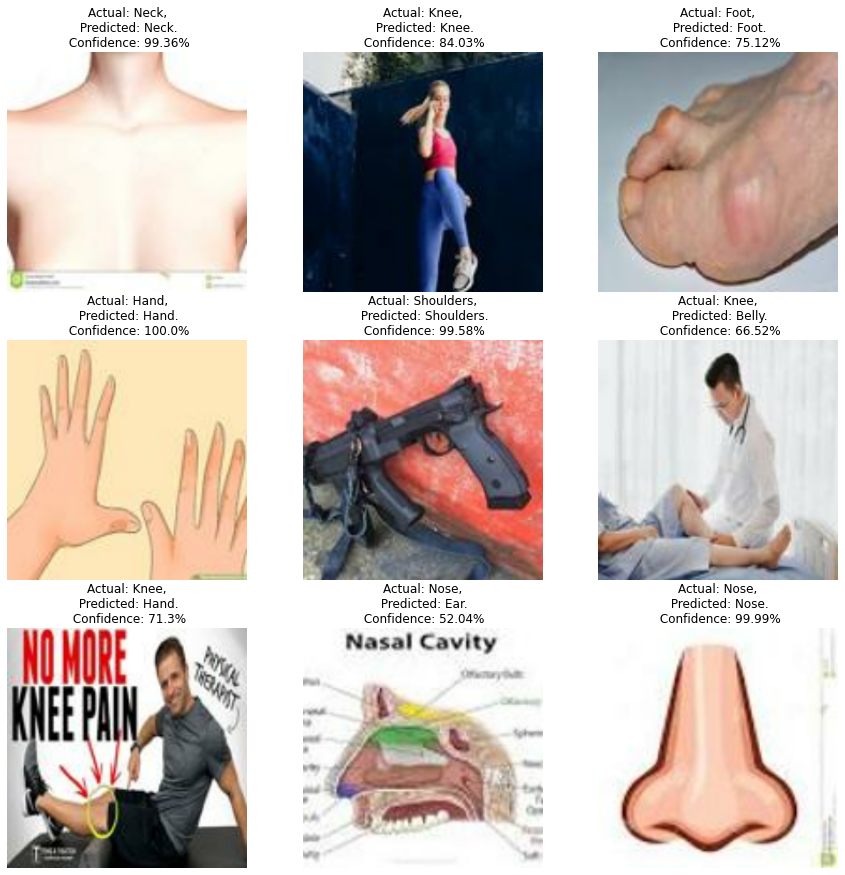

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in valid_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")